**Submitters:**

- Arkadi Doktorovich – 325118610  
- Ariel Lemberberg – 212097877  
- Elia Meerson – 211819750

In [1]:
#התקנות וייבוא ספריות

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2  # החלפנו את decord ב-opencv
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import VideoMAEImageProcessor, VideoMAEModel

# הגדרת התקן (GPU/CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# נתיבים (ודא שהם נכונים אצלך)
DATA_ROOT = "data/something-something-v2"
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")
LABEL_DIR = os.path.join(DATA_ROOT, "labels")

Device: cuda


In [2]:
#הגדרת המודל ופונקציית טעינת וידאו

# 1. טעינת המודל הגולמי (Backbone)
processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
backbone = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base").to(DEVICE)
backbone.eval()  # נקפיא אותו כי הוא כבד מאוד לאימון

# 2. פונקציית טעינת וידאו יציבה (OpenCV)
def load_video_cv2(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        return None

    # בחירת אינדקסים בצורה אחידה
    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    frames = []

    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            # המרה מ-BGR (של OpenCV) ל-RGB (של המודל)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            # אם פריימים חסרים, נשכפל את האחרון
            if len(frames) > 0:
                frames.append(frames[-1])

    cap.release()

    # בדיקת תקינות סופית - אם לא הצלחנו להשיג פריימים
    if len(frames) < num_frames:
        if len(frames) == 0: return None
        # Padding
        while len(frames) < num_frames:
            frames.append(frames[-1])

    return frames # מחזיר רשימה של numpy arrays

In [5]:
import sys
import gc

# הגדרות לריצה
SAVE_EVERY = 1000   # שמירת גיבוי כל 1000 סרטונים
PRINT_ERRORS = True # האם להדפיס שגיאות ספציפיות למסך

# משתנים למעקב סטטיסטי
stats = {
    "total": 0,
    "success": 0,
    "file_not_found": 0,
    "opencv_error": 0,
    "nan_output": 0, # מודל שהוציא ערכים לא חוקיים
    "zeros_output": 0 # מודל שהוציא רק אפסים
}

embeddings = []
labels = []
valid_video_ids = [] # לשמור איזה וידאו שייך לאיזה וקטור

# טעינת המידע
with open(os.path.join(LABEL_DIR, "labels.json")) as f:
    id_to_label = json.load(f)
label_to_id = {k: int(v) for k, v in id_to_label.items()}

with open(os.path.join(LABEL_DIR, "train.json")) as f:
    train_data = json.load(f)

print(f"Total dataset size: {len(train_data)}")

# --- פונקציה לבדיקת הוקטור ---
def validate_embedding(emb):
    if np.isnan(emb).any() or np.isinf(emb).any():
        return False, "Contains NaN/Inf"
    if np.all(emb == 0):
        return False, "All Zeros"
    if emb.shape != (768,): # מוודא שהגודל נכון
        return False, f"Wrong shape {emb.shape}"
    return True, "OK"

# --- הריצה הראשית ---
print("Starting Robust Extraction...")
pbar = tqdm(train_data[:200000]) # רץ על 20 אלף ראשונים לדוגמה

for i, item in enumerate(pbar):
    video_id = item["id"]
    stats["total"] += 1
    
    # 1. בדיקת לייבל
    raw_template = item["template"].replace("[", "").replace("]", "")
    if raw_template not in label_to_id:
        continue

    # 2. בדיקת קיום קובץ
    video_path = os.path.join(VIDEO_DIR, f"{video_id}.webm")
    if not os.path.exists(video_path):
        stats["file_not_found"] += 1
        continue

    try:
        # 3. טעינת וידאו עם OpenCV (הפונקציה שכתבנו קודם)
        frames = load_video_cv2(video_path)
        
        if frames is None:
            stats["opencv_error"] += 1
            if PRINT_ERRORS: pbar.write(f"Bad Video: {video_id}")
            continue

        # 4. הרצת המודל
        inputs = processor(list(frames), return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            outputs = backbone(**inputs)
            emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

        # 5. ולידציה לוקטור שיצא
        is_valid, reason = validate_embedding(emb)
        if not is_valid:
            if reason == "Contains NaN/Inf": stats["nan_output"] += 1
            elif reason == "All Zeros": stats["zeros_output"] += 1
            if PRINT_ERRORS: pbar.write(f"Invalid Embedding {video_id}: {reason}")
            continue

        # הכל תקין
        embeddings.append(emb)
        labels.append(label_to_id[raw_template])
        valid_video_ids.append(video_id)
        stats["success"] += 1

    except Exception as e:
        # תופס כל שגיאה אחרת (כמו CUDA OOM)
        pbar.write(f"CRITICAL ERROR on {video_id}: {str(e)}")
        # ניקוי זיכרון למקרה של קריסה
        torch.cuda.empty_cache()
        continue

    # עדכון הבר בזמן אמת
    pbar.set_postfix(ok=stats['success'], err=stats['opencv_error'], nan=stats['nan_output'])

    # --- מנגנון שמירה אוטומטי (Checkpoint) ---
    if len(embeddings) > 0 and len(embeddings) % SAVE_EVERY == 0:
        np.save("embeddings_temp.npy", np.stack(embeddings))
        np.save("labels_temp.npy", np.array(labels))
        # ניקוי זיכרון RAM
        gc.collect()

# שמירה סופית
print("\n--- Final Stats ---")
print(json.dumps(stats, indent=2))

if len(embeddings) > 0:
    embeddings = np.stack(embeddings)
    labels = np.array(labels)
    np.save("embeddings.npy", embeddings)
    np.save("labels.npy", labels)
    print(f"Saved {len(embeddings)} vectors successfully.")
else:
    print("Warning: No embeddings were extracted!")

Total dataset size: 168913
Starting Robust Extraction...


100%|██████████████████████████████████████████████| 168913/168913 [19:45:28<00:00,  2.37it/s, err=0, nan=0, ok=168913]



--- Final Stats ---
{
  "total": 168913,
  "success": 168913,
  "file_not_found": 0,
  "opencv_error": 0,
  "nan_output": 0,
  "zeros_output": 0
}
Saved 168913 vectors successfully.


In [3]:
#אימון המודל (החלק האלגוריתמי)

# טעינה מחדש (למקרה שהרצתם את החלק הקודם בנפרד)
embeddings = np.load("embeddings.npy")
labels = np.load("labels.npy")

# חלוקה למחלקות אימון (Train) ומחלקות חדשות (Test/Novel)
all_classes = np.unique(labels)
np.random.seed(42)
np.random.shuffle(all_classes)

TRAIN_CLASSES = all_classes[:100]  # נלמד על 100 מחלקות
NOVEL_CLASSES = all_classes[100:]  # נבחן על השאר

# --- המודל שלנו (Prototypical Net Adapter) ---
class AdapterNet(nn.Module):
    def __init__(self):
        super(AdapterNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128) # הקטנה ל-128 מימדים
        )

    def forward(self, x):
        return self.fc(x)

# הכנת דאטה לאימון
train_mask = np.isin(labels, TRAIN_CLASSES)
X_train = torch.tensor(embeddings[train_mask]).float().to(DEVICE)
y_train = torch.tensor(labels[train_mask]).long().to(DEVICE)

# מיפוי לייבלים ל-0..N
unique_labels = torch.unique(y_train)
label_map = {l.item(): i for i, l in enumerate(unique_labels)}
y_train_mapped = torch.tensor([label_map[l.item()] for l in y_train]).to(DEVICE)

# --- לולאת האימון ---
model = AdapterNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting Few-Shot Training Loop...")
model.train()

# הגדרות לאימון האפיזודי
N_WAY = 5      # 5 מחלקות בכל "מבחן"
K_SHOT = 5     # 5 דוגמאות למידה
Q_QUERY = 10   # 10 דוגמאות בדיקה
EPISODES = 1000 # כמה סיבובים לרוץ

for ep in range(EPISODES):
    # 1. בחירת מחלקות רנדומליות
    selected_classes = np.random.choice(list(label_map.values()), N_WAY, replace=False)

    support_set = []
    query_set = []
    query_labels = []

    for i, cls in enumerate(selected_classes):
        # מציאת כל הדוגמאות של המחלקה
        idxs = (y_train_mapped == cls).nonzero(as_tuple=True)[0]
        if len(idxs) < K_SHOT + Q_QUERY: continue

        # בחירה רנדומלית
        perm = torch.randperm(len(idxs))
        selected_idxs = idxs[perm[:K_SHOT + Q_QUERY]]

        # העברה דרך הרשת שלנו
        features = model(X_train[selected_idxs])

        support_set.append(features[:K_SHOT])
        query_set.append(features[K_SHOT:])
        query_labels.extend([i] * Q_QUERY) # התווית היא האינדקס היחסי (0-4)

    if len(support_set) < N_WAY: continue # במקרה נדיר שאין מספיק דוגמאות

    # בניית טנזורים
    S = torch.stack(support_set)      # (Way, Shot, Dim)
    Q = torch.cat(query_set)          # (Way*Query, Dim)
    Targets = torch.tensor(query_labels).long().to(DEVICE)

    # חישוב הפרוטוטייפ (ממוצע ה-Support)
    prototypes = S.mean(dim=1)

    # חישוב מרחקים (בין Query ל-Prototypes)
    # שימוש במרחק אוקלידי שלילי
    dists = torch.cdist(Q, prototypes)
    scores = -dists

    # חישוב Loss ועדכון
    loss = nn.CrossEntropyLoss()(scores, Targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 100 == 0:
        print(f"Episode {ep}: Loss = {loss.item():.4f}")

print("Training Finished!")

Starting Few-Shot Training Loop...
Episode 0: Loss = 1.8101
Episode 100: Loss = 1.6778
Episode 200: Loss = 1.6977
Episode 300: Loss = 1.6767
Episode 400: Loss = 1.6687
Episode 500: Loss = 1.6974
Episode 600: Loss = 1.6460
Episode 700: Loss = 1.6609
Episode 800: Loss = 1.6733
Episode 900: Loss = 1.6407
Training Finished!


In [6]:
novel_mask = np.isin(labels, NOVEL_CLASSES)
unique, counts = np.unique(labels[novel_mask], return_counts=True)
print(f"Novel classes with data: {len(unique)}")

Novel classes with data: 74


In [4]:
#תא 5: בדיקה

def test_few_shot(model, embeddings, labels, novel_classes, n_way=5, k_shot=5):
    model.eval()

    # הכנת הנתונים החדשים
    novel_mask = np.isin(labels, novel_classes)
    X_novel = torch.tensor(embeddings[novel_mask]).float().to(DEVICE)
    y_novel = torch.tensor(labels[novel_mask]).long().to(DEVICE)

    # המרת כל הוקטורים החדשים באמצעות המודל שאומן
    with torch.no_grad():
        X_novel_transformed = model(X_novel)

    # הרצת 1000 ניסויים לממוצע
    accuracies = []

    for _ in range(1000):
        # בחירת N מחלקות
        available_classes = np.unique(y_novel.cpu().numpy())
        if len(available_classes) < n_way: break

        selected_classes = np.random.choice(available_classes, n_way, replace=False)

        prototypes = []
        queries = []
        targets = []

        valid_episode = True
        for i, cls in enumerate(selected_classes):
            # שליפת אינדקסים של המחלקה הנוכחית
            cls_idxs = (y_novel == cls).nonzero(as_tuple=True)[0]
            if len(cls_idxs) < k_shot + 1:
                valid_episode = False
                break

            # ערבוב
            perm = torch.randperm(len(cls_idxs))
            # K ללמידה
            support_idxs = cls_idxs[perm[:k_shot]]
            # 1 לבדיקה (לצורך הפשטות בניסוי)
            query_idxs = cls_idxs[perm[k_shot:k_shot+1]]

            proto = X_novel_transformed[support_idxs].mean(dim=0)
            prototypes.append(proto)
            queries.append(X_novel_transformed[query_idxs])
            targets.append(i)

        if not valid_episode: continue

        prototypes = torch.stack(prototypes)
        queries = torch.cat(queries)

        # מי הקרוב ביותר?
        dists = torch.cdist(queries, prototypes)
        predictions = torch.argmin(dists, dim=1).cpu().numpy()
        targets = np.array(targets)

        acc = (predictions == targets).mean()
        accuracies.append(acc)

    return np.mean(accuracies)

# הרצת הבדיקה
print("Testing on NOVEL classes...")
final_acc = test_few_shot(model, embeddings, labels, NOVEL_CLASSES, n_way=5, k_shot=5)
print(f"Final 5-Way 5-Shot Accuracy: {final_acc*100:.2f}%")

Testing on NOVEL classes...
Final 5-Way 5-Shot Accuracy: 33.38%


In [7]:
import random
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, embeddings, labels):
        # המרת ההטבעות והלייבלים ל-tensors של PyTorch
        self.X = torch.tensor(embeddings).float()
        self.y = torch.tensor(labels).long()

        # יצירת מילון שמקשר כל לייבל לאינדקסים שלו
        self.label_to_indices = {}
        for idx, label in enumerate(self.y):
            label = label.item()
            self.label_to_indices.setdefault(label, []).append(idx)

        # רשימת כל הלייבלים הקיימים
        self.labels = list(self.label_to_indices.keys())

    def __len__(self):
        # אורך הדאטהסט הוא מספר ההטבעות
        return len(self.X)

    def __getitem__(self, idx):
        # בוחר את האנקור (Anchor) לפי האינדקס
        anchor = self.X[idx]
        anchor_label = self.y[idx].item()

        # בחירת פוזיטיב (אותו לייבל, דוגמה אחרת)
        pos_idx = idx
        while pos_idx == idx: # לוודא שלא נבחר אותו אינדקס
            pos_idx = random.choice(self.label_to_indices[anchor_label])
        positive = self.X[pos_idx]

        # בחירת נגטיב (לייבל שונה)
        neg_label = random.choice([l for l in self.labels if l != anchor_label])
        neg_idx = random.choice(self.label_to_indices[neg_label])
        negative = self.X[neg_idx]

        # מחזיר את שלושת המרכיבים של ה-Triplet
        return anchor, positive, negative

In [8]:
# פונקציית הלוס ל-Triplet: מקסימום של מרחק בין אנקור-פוזיטיב ומינוס אנקור-נגטיב + מרג'ין
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

# יצירת דאטהסט טריפלט מההטבעות והלייבלים של סט האימון
triplet_dataset = TripletDataset(
    embeddings[train_mask],
    labels[train_mask]
)

# יצירת DataLoader כדי לרוץ על הדאטהסט ב-batches
triplet_loader = DataLoader(
    triplet_dataset,
    batch_size=256, # מספר דוגמאות בכל batch
    shuffle=True, # ערבוב הדאטה בכל אפוק
    drop_last=True # לוודא שכל batch מלא
)

In [9]:
# מודל AdapterNet שיורד ממימד 768 ל-128 (למשל) ומוכן ל-DEVICE (GPU/CPU)
model = AdapterNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # אופטימייזר Adam

EPOCHS = 10 # מספר אפוקים לאימון
model.train() # מצב אימון

print("Starting Contrastive (Triplet) Pretraining...")

for epoch in range(EPOCHS):
    total_loss = 0.0 # איסוף סך הלוס לכל אפוק

    for anchor, positive, negative in triplet_loader:
        # העברת הטריפלט ל-DEVICE (GPU אם זמין)
        anchor = anchor.to(DEVICE)
        positive = positive.to(DEVICE)
        negative = negative.to(DEVICE)

        # Forward pass
        a = model(anchor) 
        p = model(positive) 
        n = model(negative) 

        # חישוב ה-Triplet Loss
        loss = triplet_loss(a, p, n)

        # איפוס גרדיאנטים
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(triplet_loader) # ממוצע הלוס לכל האפוק
    print(f"Epoch {epoch+1}/{EPOCHS} - Triplet Loss: {avg_loss:.4f}")

print("Contrastive Pretraining Finished!")

Starting Contrastive (Triplet) Pretraining...
Epoch 1/10 - Triplet Loss: 0.6488
Epoch 2/10 - Triplet Loss: 0.5436
Epoch 3/10 - Triplet Loss: 0.5009
Epoch 4/10 - Triplet Loss: 0.4757
Epoch 5/10 - Triplet Loss: 0.4548
Epoch 6/10 - Triplet Loss: 0.4304
Epoch 7/10 - Triplet Loss: 0.4276
Epoch 8/10 - Triplet Loss: 0.4110
Epoch 9/10 - Triplet Loss: 0.3924
Epoch 10/10 - Triplet Loss: 0.3971
Contrastive Pretraining Finished!


In [10]:
# הרצת הבדיקה
print("Testing on NOVEL classes...")
final_acc = test_few_shot(model, embeddings, labels, NOVEL_CLASSES, n_way=5, k_shot=5)
print(f"Final 5-Way 5-Shot Accuracy: {final_acc*100:.2f}%")

Testing on NOVEL classes...
Final 5-Way 5-Shot Accuracy: 60.32%


In [12]:
def per_novel_class_stats(
    model,
    embeddings,
    labels,
    novel_classes,
    n_way=5,
    k_shot=5,
    episodes_per_class=200
):
    # מעבר למצב evaluation (לא מחשב גרדיאנטים)
    model.eval()

    results = []

    # הכנת דאטה של מחלקות נובליות בלבד
    novel_mask = np.isin(labels, novel_classes)
    X_novel = torch.tensor(embeddings[novel_mask]).float().to(DEVICE)
    y_novel = torch.tensor(labels[novel_mask]).long().to(DEVICE)

    # העברת כל הוקטורים דרך המודל (למשל AdapterNet)
    with torch.no_grad():
        X_novel = model(X_novel)

    all_novel_classes = np.unique(y_novel.cpu().numpy())

    for target_class in all_novel_classes:
        cls_idxs = (y_novel == target_class).nonzero(as_tuple=True)[0]
        num_samples = len(cls_idxs)

        # אם אין מספיק דוגמאות → דילוג על המחלקה
        if num_samples < k_shot + 1:
            continue

        # אחסון accuracy לכל episode
        accs = []

        for _ in range(episodes_per_class):
            # בוחרים מחלקות נוספות
            other_classes = [c for c in all_novel_classes if c != target_class]
            if len(other_classes) < n_way - 1: 
                break

            selected_classes = [target_class] + list(
                np.random.choice(other_classes, n_way - 1, replace=False)
            )

            prototypes = []
            queries = []
            targets = []

            valid = True

            for i, cls in enumerate(selected_classes):
                idxs = (y_novel == cls).nonzero(as_tuple=True)[0]
                if len(idxs) < k_shot + 1: # אם אין מספיק דוגמאות → episode לא תקין
                    valid = False
                    break

                perm = torch.randperm(len(idxs))
                support_idxs = idxs[perm[:k_shot]]
                query_idx = idxs[perm[k_shot:k_shot+1]]

                proto = X_novel[support_idxs].mean(dim=0)
                prototypes.append(proto)
                queries.append(X_novel[query_idx])
                targets.append(i)

            if not valid:
                continue

            # חישוב מרחקים בין Query לפרוטוטייפים
            prototypes = torch.stack(prototypes)
            queries = torch.cat(queries)
            targets = torch.tensor(targets).to(DEVICE)

            dists = torch.cdist(queries, prototypes)
            preds = torch.argmin(dists, dim=1) # ניבוי הפרוטוטייפ הקרוב ביותר

            accs.append((preds == targets).float().mean().item()) # accuracy של episode

        if len(accs) > 0: # ממוצע accuracy לכל המחלקה
            results.append({
                "class": int(target_class),
                "num_videos": num_samples,
                "accuracy": np.mean(accs) * 100
            })

    return results

In [17]:
results = per_novel_class_stats(
    model,
    embeddings,
    labels,
    NOVEL_CLASSES,
    n_way=5,
    k_shot=5,
    episodes_per_class=200
)

with open(os.path.join(LABEL_DIR, "labels.json")) as f:
    id_to_label = json.load(f)

id_to_label_name = {int(v): k for k, v in id_to_label.items()}

max_name_len = max(len(id_to_label_name[r["class"]]) for r in results)

print(f"{'Class Name'.ljust(max_name_len)} | #Videos | Accuracy (%)")
print("-" * (max_name_len + 26))

for r in sorted(results, key=lambda x: x["num_videos"]):
    class_name = id_to_label_name[r["class"]]
    print(
        f"{class_name.ljust(max_name_len)} | "
        f"{r['num_videos']:7d} | "
        f"{r['accuracy']:10.2f}"
    )

Class Name                                                                         | #Videos | Accuracy (%)
------------------------------------------------------------------------------------------------------------
Spilling something behind something                                                |     111 |      57.90
Poking something so that it spins around                                           |     153 |      59.10
Putting something onto a slanted surface but it doesn't glide down                 |     156 |      57.30
Poking a hole into something soft                                                  |     185 |      54.90
Pulling two ends of something so that it separates into two pieces                 |     199 |      61.40
Poking a stack of something without the stack collapsing                           |     217 |      60.30
Failing to put something into something because something does not fit             |     273 |      56.40
Pouring something onto something         

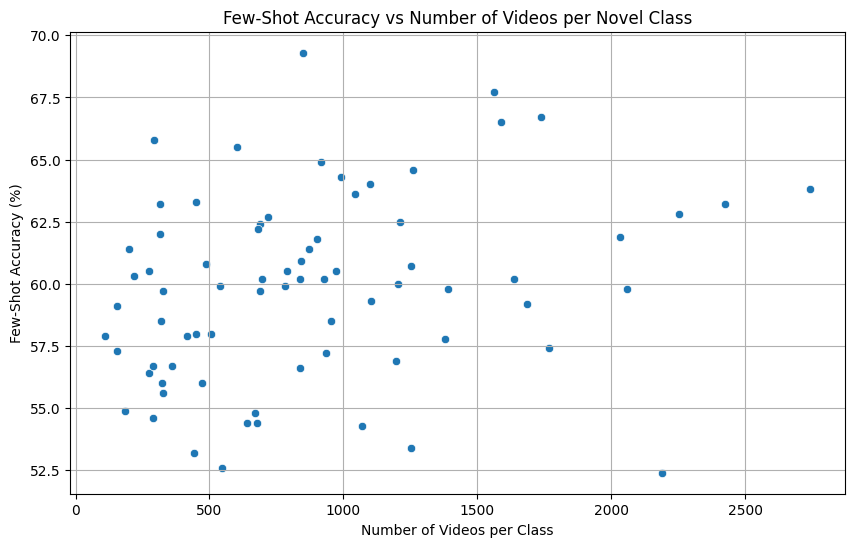

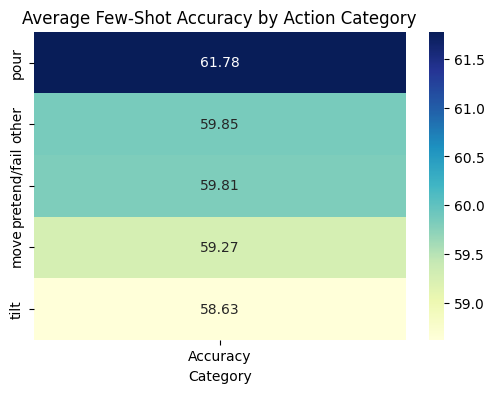

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- הכנת DataFrame ---
df = pd.DataFrame([
    {
        "Class Name": id_to_label_name[r["class"]],
        "#Videos": r["num_videos"],
        "Accuracy": r["accuracy"]
    }
    for r in results
])

# --- Scatter: #Videos vs Accuracy ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="#Videos", y="Accuracy")
plt.title("Few-Shot Accuracy vs Number of Videos per Novel Class")
plt.xlabel("Number of Videos per Class")
plt.ylabel("Few-Shot Accuracy (%)")
plt.grid(True)
plt.show()

# --- Heatmap by Action Type Keywords ---
# נניח שיש קטגוריות בסיסיות לפי מילים: pour, move, tilt, pretend/fail
categories = {
    "pour": ["pour"],
    "move": ["move", "pull", "push"],
    "tilt": ["tilt", "tip"],
    "pretend/fail": ["pretend", "fail"],
    "other": []
}

def categorize_action(name):
    name_lower = name.lower()
    for cat, keywords in categories.items():
        if any(k in name_lower for k in keywords):
            return cat
    return "other"

df["Category"] = df["Class Name"].apply(categorize_action)

# חישוב ממוצע Accuracy לפי Category
heatmap_data = df.groupby("Category")["Accuracy"].mean().sort_values(ascending=False).to_frame()

plt.figure(figsize=(6,4))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Few-Shot Accuracy by Action Category")
plt.xlabel("Category")
plt.ylabel("")
plt.show()